## Часть 1: Подготовка данных и применение модели `mbt2018-mean`.

#### Добавление необходимых путей и импорт библиотек.

In [1]:
import sys
import os
root_path = os.getcwd()
sys.path.append(os.path.join(root_path,'compressai'))
#sys.path

In [2]:
from compressai.zoo import mbt2018_mean
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

#### В качетсве данных была выбрана поcледовательность пяти кадров из датасета SINTEL (взяты из директории demo-frames из репозитория RAFT), изображения приводим к размеру (H, W) = (512, 1024).

frame_0021.png resized and saved to images\orig_resize_frames
frame_0022.png resized and saved to images\orig_resize_frames
frame_0023.png resized and saved to images\orig_resize_frames
frame_0024.png resized and saved to images\orig_resize_frames
frame_0025.png resized and saved to images\orig_resize_frames


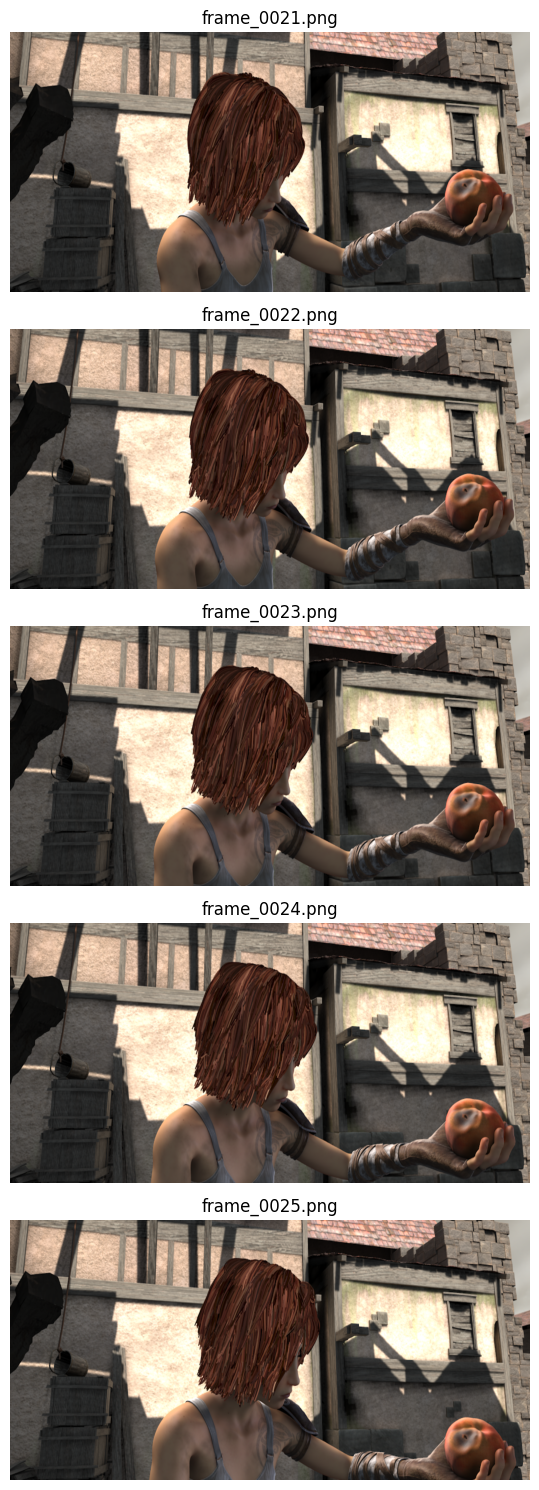

In [3]:
orig_folder = 'images\\demo-frames'
orig_resize_folder = 'images\\orig_resize_frames'
reconstr_folder = 'images\\reconstr_frames'

resize_transform = transforms.Resize((512, 1024))

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))
for i, filename in enumerate(os.listdir(orig_folder)):
    file_path = os.path.join(orig_folder, filename)
    img = Image.open(file_path).convert('RGB')  

    resized_img = resize_transform(img)
    
    output_path = os.path.join(orig_resize_folder, filename)
    resized_img.save(output_path)

    print(f'{filename} resized and saved to {orig_resize_folder}')

    axs[i].imshow(resized_img)
    axs[i].set_title(f'{filename}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### Загрузка предобученной модели mbt2018-mean

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = mbt2018_mean(quality=1, pretrained=True).to(device)
net.eval()
print(device)


cuda:0


### Применение кодека mbt2018-mean к изображениям ( (H, W) = (512, 1024) ).

#### Функция для подсчета BPP.

In [5]:
def compute_BPP(bin_streams, H, W):
    len_binary_sreams = len(bin_streams[0][0]) + len(bin_streams[1][0])
    return (float(8) * len_binary_sreams / (H * W))


#### Применение mbt2018-mean к изображениям, подсчет BPP и визуализация результатов.

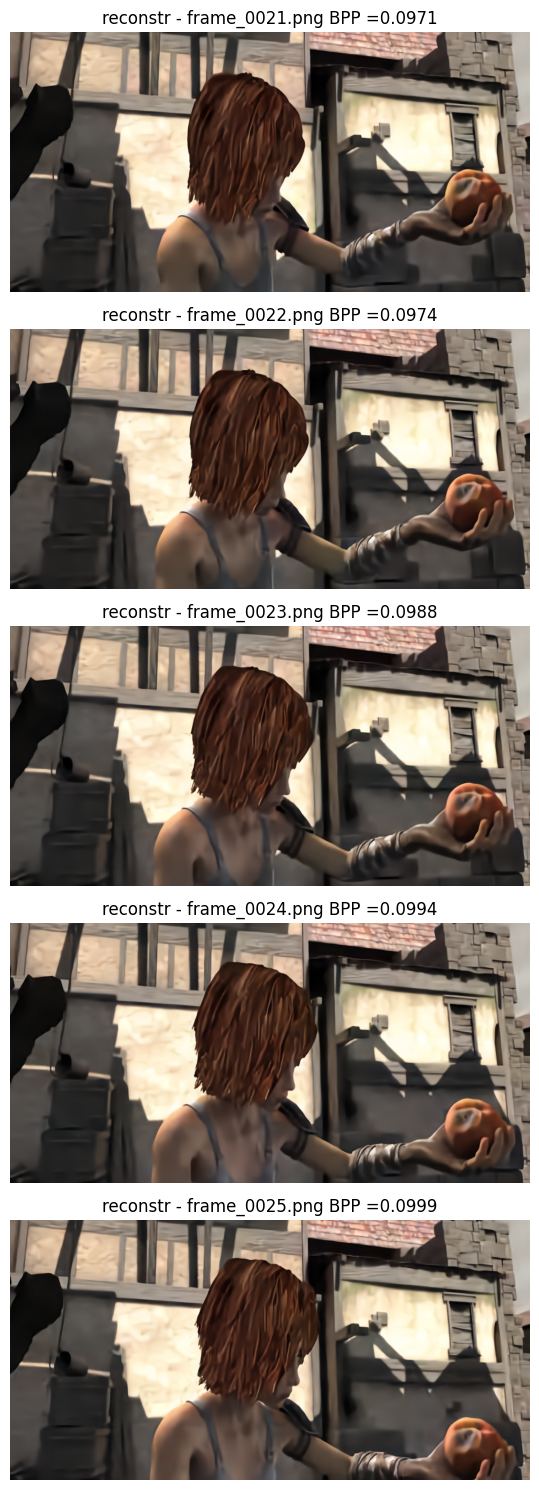

In [9]:

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))
for i, filename in enumerate(sorted(os.listdir(orig_resize_folder))):
    
    img_path = os.path.join(orig_resize_folder, filename)
    img = Image.open(img_path).convert('RGB')

    transform = transforms.ToTensor()
    x = transform(img).unsqueeze(0).to(device)
    
    y = net.compress(x)
    BPP = compute_BPP(y['strings'], 512, 1024)
    bpp_4f = '{:.4f}'.format(BPP)
    z = list(y.values())
    rec_tensor = net.decompress(z[0],z[1])
    out_img = transforms.ToPILImage()(rec_tensor['x_hat'].squeeze().cpu())
    
    output_path = os.path.join(reconstr_folder, f'reconstructed_{filename}')
    out_img.save(output_path)

    axs[i].imshow(out_img)
    axs[i].set_title(f'reconstr - {filename} BPP ={bpp_4f}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Часть 2: Вычисление оптических потоков с помощью `RAFT`.

In [10]:
sys.path.append(os.path.join(root_path,'RAFT'))
sys.path.append(os.path.join(root_path,"RAFT\\core"))
#sys.path

In [11]:
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

### Определение путей для сохранения визуализаций оптических потоков

- **opt_flow_between_orig** - Оптические потоки между оригинальными кадрами.
- **pt_flow_between_reconstr** - Оптические потоки между реконструированными кадрами (после применения модели mbt2018-mean).
- **opt_flow_reconstr_orig** - Реконструкции оптических потоков между оригинальными кадрами (после применения модели mbt2018-mean).
- **opt_flow_reconstr_reconstr** - Реконструкции оптических потоков между реконструированными кадрами (после применения модели mbt2018-mean).



In [23]:
opt_flow_between_orig = 'opt_flow\\between_orig'# OtFlow между оригинальными изображениями
opt_flow_between_reconstr = 'opt_flow\\between_reconstr'# OptFlow между реконструированными кадрами
opt_flow_reconstr_orig = 'opt_flow\\reconstr_b-n_orig'# Реконструкци оптических потоков (между оригинальными кадрами)
opt_flow_reconstr_reconstr = 'opt_flow\\reconstr_b-n_reconstr'# Реконструкции оптических потоков (между руконструированными кадрами)

### Вспомогательные функции для использования RAFT.
За основу взят код из файла demo.py из репозитория RAFT

In [24]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(device)

def demo(args, input_folder, output_folder):
    model = torch.nn.DataParallel(RAFT(args))
    model.load_state_dict(torch.load(args.model))

    model = model.module
    model.to(device)
    model.eval()
    #print("bbbb")
    with torch.no_grad():
        images = glob.glob(os.path.join(input_folder, '*.png'))
        #print("b")
        images = sorted(images)
        for idx, (imfile1, imfile2) in enumerate(zip(images[:-1], images[1:])):
            image1 = load_image(imfile1)
            image2 = load_image(imfile2)
            #print("k")
            padder = InputPadder(image1.shape)
            image1, image2 = padder.pad(image1, image2)
            flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

            opt_flow = flow_up[0].permute(1,2,0).cpu().numpy()
            
            img_flo = flow_viz.flow_to_image(opt_flow)

            output_filename = f'flow_{idx}-{idx+1}.png'
            output_path = os.path.join(output_folder, output_filename)
            
            cv2.imwrite(output_path, img_flo[:, :, [2,1,0]])
            



### Вычисление оптических потоков между всеми кадрами (сначала между оригинальными, затем между реконструированными) и сохранение визуализаций в указанные директории.

In [25]:
from argparse import Namespace

In [26]:
args1 = Namespace(
    model='models/models/raft-things.pth',
    path=None,
    small=False,
    mixed_precision=False,
    alternate_corr=False
    )
demo(args1, orig_resize_folder, opt_flow_between_orig)
demo(args1, reconstr_folder, opt_flow_between_reconstr)

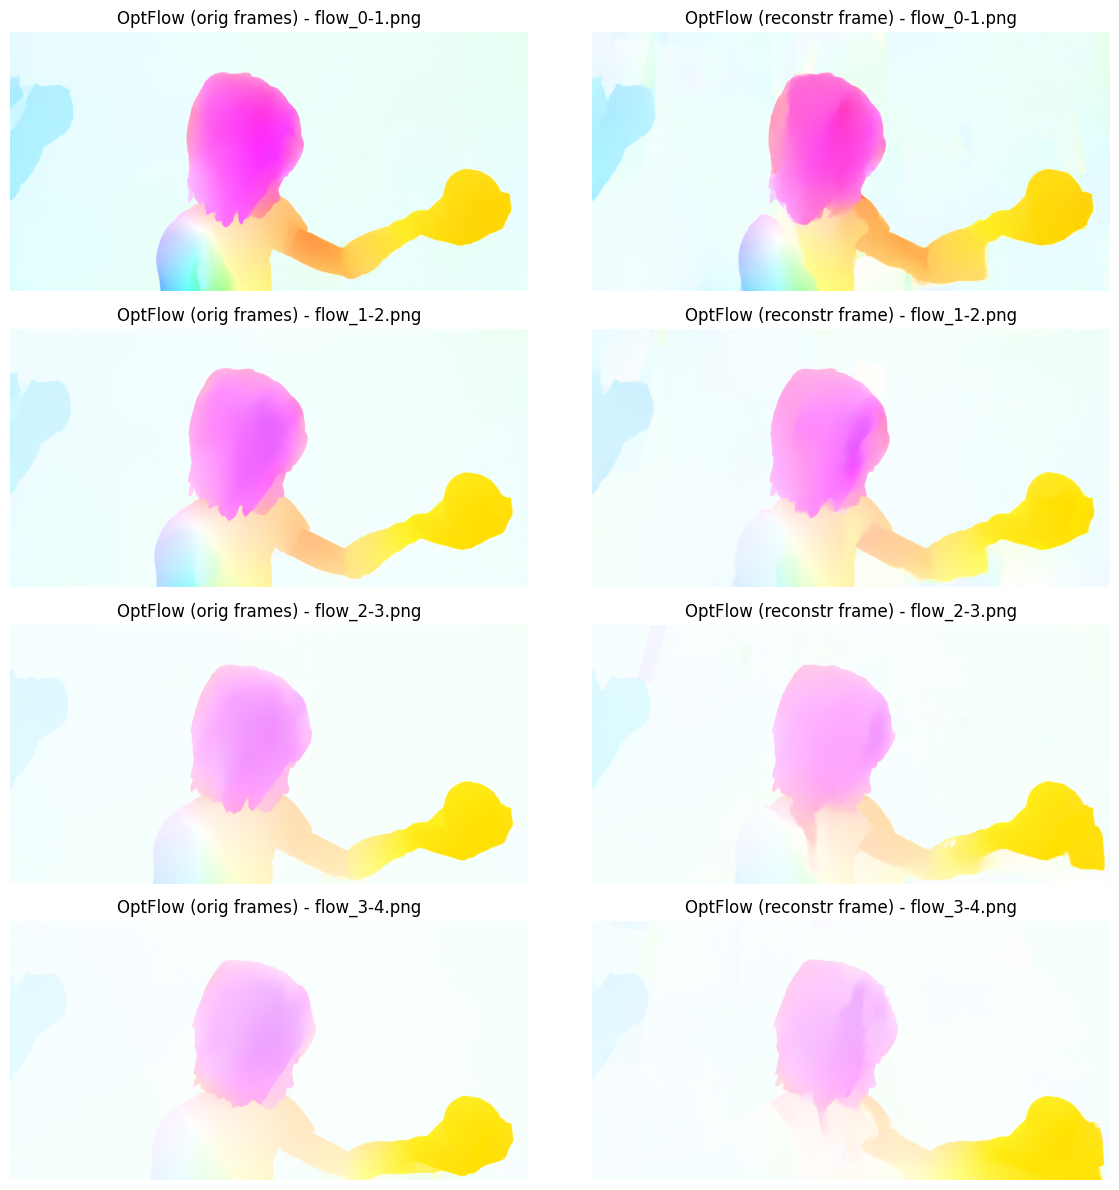

In [27]:
images1 = sorted(os.listdir(opt_flow_between_orig))
images2 = sorted(os.listdir(opt_flow_between_reconstr))

fig, axs = plt.subplots(nrows=len(images1), ncols=2, figsize=(12, 3 * len(images1)))

for i, (img1, img2) in enumerate(zip(images1, images2)):

    image_path1 = os.path.join(opt_flow_between_orig, img1)
    image_path2 = os.path.join(opt_flow_between_reconstr, img2)
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)
    
    axs[i, 0].imshow(image1)
    axs[i, 0].set_title('OptFlow (orig frames) - ' + img1)
    axs[i, 0].axis('off')  
    
    axs[i, 1].imshow(image2)
    axs[i, 1].set_title('OptFlow (reconstr frame) - ' + img2)
    axs[i, 1].axis('off') 

plt.tight_layout()
plt.show()

## Часть 3: Применение кодека `mbt2018-mean` к визуализациям (к изображениям) оптического потока и сохранение получившихся изображений в указанные директории.

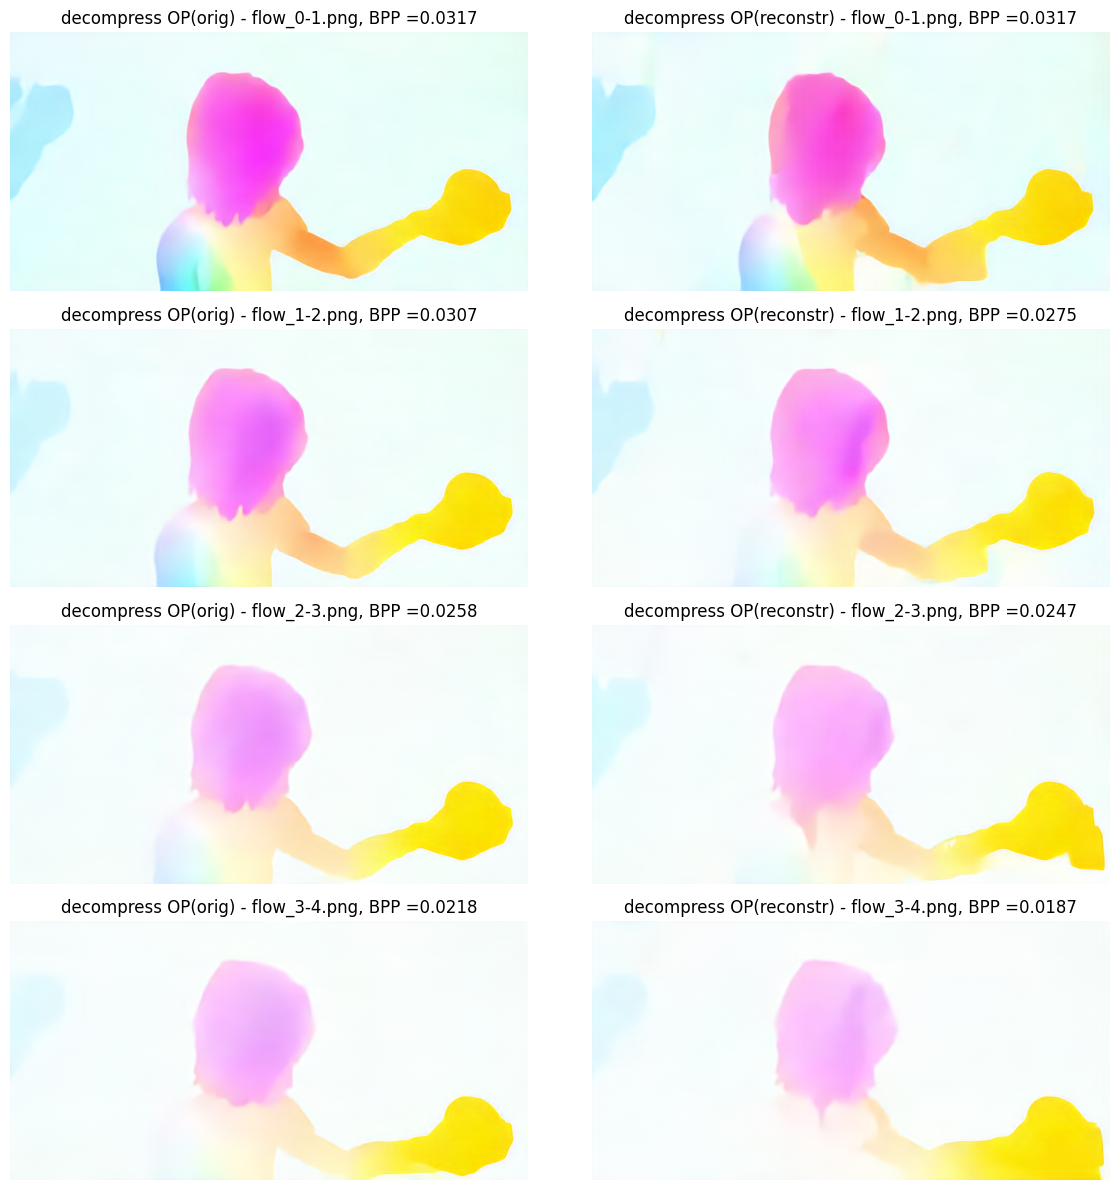

In [28]:
fig, axs = plt.subplots(4, ncols=2, figsize=(12, 3 * 4))
for i, filename in enumerate(sorted(os.listdir(opt_flow_between_orig))):
    
    img_path = os.path.join(opt_flow_between_orig, filename)
    img = Image.open(img_path).convert('RGB')

    transform = transforms.ToTensor()
    x = transform(img).unsqueeze(0).to(device)

    y = net.compress(x)
    BPP = compute_BPP(y['strings'], 512, 1024)

    bpp_4f = '{:.4f}'.format(BPP)
    z = list(y.values())
    rec_tensor = net.decompress(z[0],z[1])
    out_img = transforms.ToPILImage()(rec_tensor['x_hat'].squeeze().cpu())
    
    output_path = os.path.join(opt_flow_reconstr_orig, f'reconstr_orig_{filename}')
    out_img.save(output_path)
    axs[i,0].imshow(out_img)
    axs[i,0].set_title(f'decompress OP(orig) - {filename}, BPP ={bpp_4f}')
    axs[i,0].axis('off')


for i, filename in enumerate(sorted(os.listdir(opt_flow_between_reconstr))):
    
    img_path = os.path.join(opt_flow_between_reconstr, filename)
    img = Image.open(img_path).convert('RGB')

    transform = transforms.ToTensor()
    x = transform(img).unsqueeze(0).to(device)

    y = net.compress(x)
    BPP = compute_BPP(y['strings'], 512, 1024)
    bpp_4f = '{:.4f}'.format(BPP)
    z = list(y.values())
    rec_tensor = net.decompress(z[0],z[1])
    out_img = transforms.ToPILImage()(rec_tensor['x_hat'].squeeze().cpu())
    
    output_path = os.path.join(opt_flow_reconstr_reconstr, f'reconstr_reconstr_{filename}')
    out_img.save(output_path)
    axs[i,1].imshow(out_img)
    axs[i,1].set_title(f'decompress OP(reconstr) - {filename}, BPP ={bpp_4f}')
    axs[i,1].axis('off')

plt.tight_layout()
plt.show() 